### LangGraph With Tool and Memory

In [1]:
# Groq Call
from langchain_groq import ChatGroq

model = "deepseek-r1-distill-llama-70b"
deepseek_llm=ChatGroq(model_name=model)
response = deepseek_llm.invoke("What is the capital of India?")
print(response.content)

<think>

</think>

The capital of India is New Delhi.


In [2]:
# Call Groq Model
from langgraph.graph import StateGraph, MessagesState, START, END

def call_model(state: MessagesState):
    response = deepseek_llm.invoke(state["messages"])
    state["messages"].append(response)
    return state

call_model(state={"messages": ["What is the capital of india?"]})

{'messages': ['What is the capital of india?',
  AIMessage(content="<think>\nOkay, so I need to figure out the capital of India. Hmm, I remember learning a bit about countries and their capitals before, but I'm not entirely sure about India's. Let me think. I know some big cities in India like Mumbai and Bangalore. I think Mumbai is a major financial hub, and Bangalore is known for its tech industry. But those aren't capitals, I believe.\n\nWait, I've heard the name Delhi before. I think Delhi is the capital, but I'm not 100% certain. Let me try to recall any other clues. I remember that India is a country in South Asia, and it's a republic. The capital city is where the central government is located. I think Delhi is a union territory, not just a city, which might be a clue. Also, I've heard of New Delhi, which might be the specific part of Delhi that serves as the capital.\n\nIs there any other city that could be the capital? Maybe Kolkata or Chennai? No, I think those are more cultu

In [3]:
from langchain_core.tools import tool

@tool
def search(query: str):
    """ this is the custom tool for searching the weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degrees and sunny"
    else :
        return "the temp is 20 degrees and cloudy"
search

StructuredTool(name='search', description='this is the custom tool for searching the weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x119b84040>)

In [4]:
search.invoke("What is the weather in delhi ?")

'the temp is 45 degrees and sunny'

In [5]:
tools=[search]
llm_with_tools = deepseek_llm.bind_tools(tools)

In [6]:
response = llm_with_tools.invoke("What is the weather in delhi?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '664f5g21x', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 133, 'total_tokens': 230, 'completion_time': 0.425587879, 'prompt_time': 0.015087037, 'queue_time': 0.053818373, 'total_time': 0.440674916}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--98b4ff73-dc30-4ee4-9208-0f3de7be8435-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': '664f5g21x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 97, 'total_tokens': 230})

In [7]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '664f5g21x',
  'type': 'tool_call'}]

In [9]:
def call_model(state:MessagesState):
    question = state["messages"]
    response = llm_with_tools.invoke(question)
    return {"messages": [response]}

response = call_model({"messages": ["What is the weather in delhi?"]})
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '21aam3fxx', 'function': {'arguments': '{"query":"delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 133, 'total_tokens': 195, 'completion_time': 0.26415527, 'prompt_time': 0.008592973, 'queue_time': 0.06027060699999999, 'total_time': 0.272748243}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1c21ec8e-ce85-4f73-9bb3-adc3e454d61c-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi'}, 'id': '21aam3fxx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 62, 'total_tokens': 195})]}

In [10]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'delhi'},
  'id': '21aam3fxx',
  'type': 'tool_call'}]

In [11]:
# Memory
from langgraph.checkpoint.memory import MemorySaver

checkpoint = MemorySaver()

In [13]:
def router_function(state: MessagesState):
    question = state["messages"][-1]
    if question.tool_calls:
        return "tools"
    return END

In [12]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

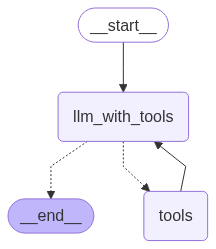

In [15]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_with_tools", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "llm_with_tools")
workflow.add_conditional_edges("llm_with_tools", router_function, {"tools": "tools", END: END})
workflow.add_edge("tools", "llm_with_tools")
workflow.add_edge("llm_with_tools", END)
app = workflow.compile(checkpointer=checkpoint)
app

In [16]:
config={"configurable": {"thread_id": "1"}}
app.invoke({"messages": ["What is the weather in delhi?"]}, config=config)

{'messages': [HumanMessage(content='What is the weather in delhi?', additional_kwargs={}, response_metadata={}, id='94bfa2af-5386-4117-951e-8489d9329a95'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nqy5tgc2x', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 202, 'prompt_tokens': 133, 'total_tokens': 335, 'completion_time': 1.070013596, 'prompt_time': 0.009060616, 'queue_time': 0.057598260000000005, 'total_time': 1.079074212}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9c791507-cd74-4d4e-9786-33ff4a428b6b-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'nqy5tgc2x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 202, 'total_tokens': 335}),
  ToolMessage(content='the temp is 45 degrees and sunny', 

In [17]:
for current in app.stream({"messages": ["What is the weather in delhi?"]}, config=config):
    for key, value in current.items():
        print(f"{key}: {value}")

llm_with_tools: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bz55p6nbe', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 190, 'prompt_tokens': 274, 'total_tokens': 464, 'completion_time': 1.092567188, 'prompt_time': 0.024250983, 'queue_time': 0.056865576, 'total_time': 1.116818171}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8b34de13-ab66-4686-9a41-b5866e2d5f40-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'bz55p6nbe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 274, 'output_tokens': 190, 'total_tokens': 464})]}
tools: {'messages': [ToolMessage(content='the temp is 45 degrees and sunny', name='search', id='cf886d4e-4a13-4b26-8d21-958b18fb18c5', tool_call_id='bz55p6nbe')]}
llm_with_tools: {'messages': [A

In [18]:
events = app.stream({"messages": ["What is the weather in indore?"]}, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (gfdgbsbxc)
 Call ID: gfdgbsbxc
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 20 degrees and cloudy
================================== Ai Message ==================================
Tool Calls:
  search (rjw6zpcmj)
 Call ID: rjw6zpcmj
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 20 degrees and cloudy
================================== Ai Message ==================================
Tool Calls:
  search (b3fketdvc)
 Call ID: b3fketdvc
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 20 degree

In [19]:
checkpoint.get(config=config)

{'v': 3,
 'ts': '2025-07-11T06:27:59.509897+00:00',
 'id': '1f05e203-08e9-6040-8017-c1254288c46c',
 'channel_versions': {'__start__': '00000000000000000000000000000018.0.9128743614097972',
  'messages': '00000000000000000000000000000025.0.10958618430494316',
  'branch:to:llm_with_tools': '00000000000000000000000000000025.0.07204819334050883',
  'branch:to:tools': '00000000000000000000000000000024.0.17494759594086906'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000017.0.34164949276087164'},
  'llm_with_tools': {'branch:to:llm_with_tools': '00000000000000000000000000000024.0.441883362133766'},
  'tools': {'branch:to:tools': '00000000000000000000000000000023.0.32566345277493025'}},
 'pending_sends': [],
 'channel_values': {'messages': [HumanMessage(content='What is the weather in delhi?', additional_kwargs={}, response_metadata={}, id='94bfa2af-5386-4117-951e-8489d9329a95'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id':

In [21]:
events = app.stream({"messages": ["In which city the temperature is 20 degrees"]}, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

In which city the temperature is 20 degrees
================================== Ai Message ==================================

The city where the temperature is 20 degrees is **Indore**.


In [22]:
checkpoint.get(config=config)

{'v': 3,
 'ts': '2025-07-11T06:29:09.266485+00:00',
 'id': '1f05e205-a229-6672-801d-a5d75e318051',
 'channel_versions': {'__start__': '00000000000000000000000000000030.0.960617461303371',
  'messages': '00000000000000000000000000000031.0.9382031400807951',
  'branch:to:llm_with_tools': '00000000000000000000000000000031.0.6796838744315021',
  'branch:to:tools': '00000000000000000000000000000029.0.6530551896837495'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000029.0.5145550598942731'},
  'llm_with_tools': {'branch:to:llm_with_tools': '00000000000000000000000000000030.0.7004674619003425'},
  'tools': {'branch:to:tools': '00000000000000000000000000000028.0.3796551669502025'}},
 'pending_sends': [],
 'channel_values': {'messages': [HumanMessage(content='What is the weather in delhi?', additional_kwargs={}, response_metadata={}, id='94bfa2af-5386-4117-951e-8489d9329a95'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nqy